In [108]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import time
import scipy
import scipy.signal
from PIL import Image
import math
import scipy.misc
from scipy.ndimage.interpolation import zoom
from scipy.stats import norm
from scipy.stats import multivariate_normal
import pywt
import scipy.ndimage as ndimage #image processing library

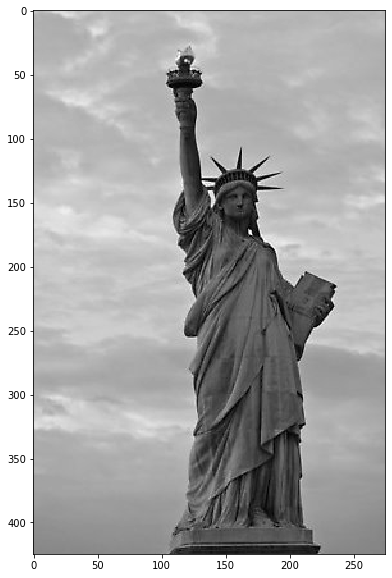

In [8]:
plt.rcParams['image.cmap'] = 'gray'  

name = 'lady_liberty1.jpeg'
lady = plt.imread(name)
lady = lady[25:450, 25:300]
plt.figure(figsize=(10,10)) # this allows you to control the size of the displayed image
plt.imshow(lady)

In [105]:
def square_around_pt(img, center, scale):
    radius = int(round(6*scale))
    i,j = center
    square_img = img[i-radius:i+radius+1, j-radius:j+radius+1] 
    new_center = (square_img.shape[0]//2,square_img.shape[0]//2) #should be a square
    
    return square_img, new_center

def haar_wavelet_filter(dim, direction='x'):
    fltr = np.ones((dim,dim))
    halfway = dim//2
    
    if direction == 'x':
        #set -1 region
        fltr[:,0:halfway] = -1
    
    elif direction == 'y':
        #set -1 region
        fltr[0:halfway,:] = -1
    
    return fltr

'''
@description: this function gets the points in a circular region around an interest point
@params: img - the image to get the circular points around
         center - the interest point around which to get the points
         scale - the scale s to multiply by 6 (radius = 6*s)
@return: circular_pts - list of tuples of the surrounding points in the circular region
'''
def get_circular_pts(img, center, scale):
    radius = 6*scale
    h,w = img.shape
    X, Y = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    circular_pts = list(zip(*np.where(mask != 0)))
    
    return circular_pts

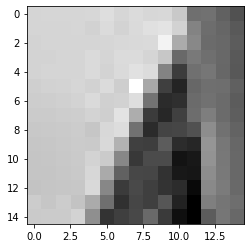

In [93]:
sq, new_center = square_around_pt(lady,center=(145, 114),scale=1.2)
plt.imshow(sq)

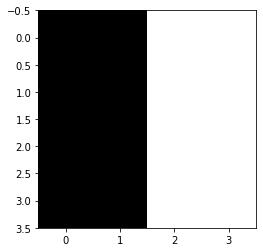

In [98]:
hw_x = haar_wavelet_filter(4,'x')
hw_y = haar_wavelet_filter(4,'y')
plt.imshow(hw_x)
plt.show()

(15, 15)


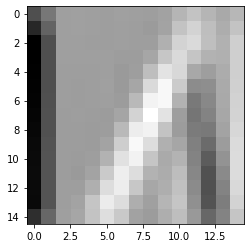

In [101]:
conv_x = scipy.signal.convolve2d(sq, hw_x, 'same')
conv_y = scipy.signal.convolve2d(sq, hw_y, 'same')
print(conv_x.shape) #retains shape after convolution
plt.imshow(conv_x)
plt.show()

The above need to be weighted with a Gaussian to get their gradients at each pixel

In [110]:
x_grad = ndimage.gaussian_filter(conv_x, sigma=2.5, order=[0,1])
y_grad = ndimage.gaussian_filter(conv_y, sigma=2.5, order=[1,0])

In [165]:
def in_sector(x, y, scale, start_angle, end_angle): 
    radius = 6*scale
    
    # Calculate polar coordinates 
    p_radius = math.sqrt(x*x + y*y) 
    p_angle = np.arctan2(y, x) #do i need to worry that this returns -pi to pi like in homework 2?
    
    return (p_angle >= start_angle and p_angle < end_angle and p_radius <= radius)

'''
@description: this function takes in a circular region and and an initial orientation window and returns
              all the pixels within that scanning region within that orientation window
@params: circular_region - list of pixels that comprise the circular region of radius 6s around
                               an interest point
         x_grad, y_grad - first order gaussian derivatives after haar wavelet has already been convolved
@return: max_orientation - orientation that corresponds to the largest vector after summing the
                           x and y responses
'''
def scanning_orientation(circular_region, scale, x_grad, y_grad):
    response_dict = {i:0 for i in range(6)}
    pi = np.pi

    for pt in circular_region:
        i,j = pt
        if in_sector(i,j,scale, 0, pi/3): #(0-pi/3)
            response_dict[0] += x_grad[i][j] + y_grad[i][j]

        elif in_sector(i,j,scale, pi/3, 2*pi/3): #(pi/3,2pi/3)
            response_dict[1] += x_grad[i][j] + y_grad[i][j]

        elif in_sector(i,j,scale, 2*pi/3, pi): #(2pi/3,pi)
            response_dict[2] += x_grad[i][j] + y_grad[i][j]

        elif in_sector(i,j,scale, pi, 4*pi/3): #(pi,4pi/3)
            response_dict[3] += x_grad[i][j] + y_grad[i][j]

        elif in_sector(i,j,scale,4*pi/3,5*pi/3): #(4pi/3,5pi/3)
            response_dict[4] += x_grad[i][j] + y_grad[i][j]

        elif in_sector(i,j,scale, 5*pi/3, 0): #(4pi/3,5pi/3)
            response_dict[5] += x_grad[i][j] + y_grad[i][j]
    
    print(response_dict)
    return max(response_dict.values())

def orientation(img, interest_pt, scale):
    #get the square of length 6*s around the interest point + new center
    square, new_center = square_around_pt(img,center=interest_pt,scale=scale)
    
    #create 4x4 haar wavelet filter in each direction
    hw_x = haar_wavelet_filter(4,'x') #4x4 just because
    hw_y = haar_wavelet_filter(4,'y')
    
    #apply haar wavelet filter to square in each direction
    conv_x = scipy.signal.convolve2d(square, hw_x, 'same')
    conv_y = scipy.signal.convolve2d(square, hw_y, 'same')
    
    #take the first order gaussian derivative to get the gradients of the pixels in each direction
    x_grad = ndimage.gaussian_filter(conv_x, sigma=2.5*scale, order=[0,1]) #2.5s per the paper
    y_grad = ndimage.gaussian_filter(conv_y, sigma=2.5*scale, order=[1,0])
    
    #get circular points around haar wavelet + gaussian-treated square
    circular_region = get_circular_pts(sq, new_center, scale) 
    
    #scan over shifting region of pi/3 around the interest point and return the largest orientation
    max_orientation = scanning_orientation(circular_region, scale, x_grad, y_grad)

    return max_orientation

In [162]:
orientation(lady,(145, 114),scale=1.2)

{0: 4189.8433773924135, 1: 1718.4672201491583, 2: 0, 3: 0, 4: 0, 5: 0}


4189.8433773924135

In [164]:
orientation(lady,(406, 213),scale=1.2)

{0: 908.4925899379531, 1: 742.0389725879769, 2: 0, 3: 0, 4: 0, 5: 0}


908.4925899379531